 # Gender classification using keras API

In [1]:
import numpy as np  # Data manipulation
import pandas as pd # Dataframe manipulation 
import matplotlib.pyplot as plt # Plotting the data and the results
import matplotlib.image as mpimg # For displaying imagees
%matplotlib inline
from keras import models
from keras import layers
#import keras.preprocessing  as kp
#from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import optimizers

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Exploratory Data Analysis

**Let's first prep the ImageDataGenerator with minor data augmentations to keep the training time optimal.**

In [82]:
size = 249
target_size = (size,size,3)

In [83]:
train_datagen = ImageDataGenerator( # Data Augumentation for test data
rescale=1./255,
rotation_range=30,
shear_range=0.3,
zoom_range=0.3,
horizontal_flip=True,
#width_shift_range=0.4,
#height_shift_range=0.4,
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [84]:
train_gen=train_datagen.flow_from_directory('../input/gender-recognition-200k-images-celeba/Dataset/Train',
                                            target_size=(size,size),
                                            batch_size=650,
                                            class_mode='binary')

Found 160000 images belonging to 2 classes.


160000 images should be enough for the model to pick up the local patterns.

In [85]:
valid_gen=test_datagen.flow_from_directory('../input/gender-recognition-200k-images-celeba/Dataset/Validation',
                                           target_size=(size,size),
                                           batch_size=650,
                                           class_mode='binary')

Found 22598 images belonging to 2 classes.


In [ ]:
kernel_s=(3,3) # The size of kernel

Let's build the model now.

In [ ]:
model=Sequential()
model.add(layers.Conv2D(32,kernel_s,activation='relu',input_shape=(250,250,3),
                        kernel_regularizer=regularizers.l2(0.001),padding="VALID"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

In [ ]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

# Model Training

In [92]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('xception_v5_{epoch:02d}_{val_accuracy:.3f}.h5',
                                             save_best_only = True,
                                             monitor= 'val_accuracy',
                                             mode = 'max')

In [ ]:
history=model.fit(train_gen,steps_per_epoch=70,epochs=30,
                  validation_data=valid_gen,validation_steps=50,
                  callbacks= [checkpoint])

# 2nd Model Training (Xception Model)

In [87]:
#base
model2 = Sequential()
model2.add(Xception(include_top=False, pooling='avg', weights='imagenet', input_shape=target_size))
model2.add(Flatten())
model2.add(BatchNormalization())
#head
model2.add(Dense(2048, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(1024, activation='relu'))
model2.add(BatchNormalization())

model2.add(Dense(1, activation='sigmoid'))

model2.layers[0].trainable = False

In [88]:
model2.summary()
model2.compile(optimizer= 'Adam', loss = 'binary_crossentropy', metrics= 'accuracy')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_26 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_27 (Batc (None, 1024)             

In [95]:
epochs = 3
batch_size=888
history2 = model2.fit(train_gen, epochs= epochs, validation_data= valid_gen,
                    steps_per_epoch= len(train_gen.filenames)//batch_size,
                    validation_steps= len(valid_gen.filenames)//batch_size,
                    callbacks= [checkpoint]
                    )

Epoch 1/3
180/180 [==============================] - 2119s 12s/step - loss: 0.1957 - accuracy: 0.9212 - val_loss: 0.1657 - val_accuracy: 0.9366
Epoch 2/3
180/180 [==============================] - 1991s 11s/step - loss: 0.1723 - accuracy: 0.9298 - val_loss: 0.1524 - val_accuracy: 0.9380
Epoch 3/3
180/180 [==============================] - 1934s 11s/step - loss: 0.1600 - accuracy: 0.9344 - val_loss: 0.1513 - val_accuracy: 0.9392


### Let's plot the Training vs Validation loss and accuracy graphs.

<Figure size 432x288 with 0 Axes>

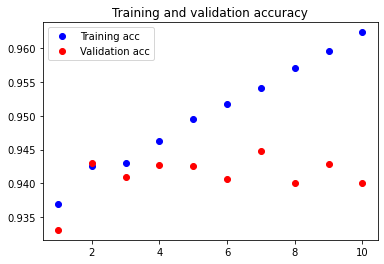

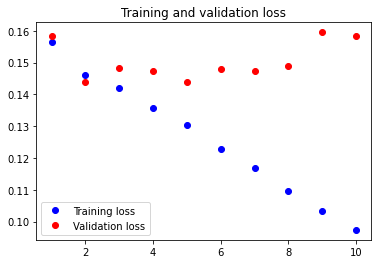

<Figure size 432x288 with 0 Axes>

In [18]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

# Model Testing

In [19]:
test_datagen1 = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen1.flow_from_directory(
'../input/gender-recognition-200k-images-celeba/Dataset/Test',
target_size=(250,250),
batch_size=32,
class_mode='binary')

Found 20001 images belonging to 2 classes.


In [100]:
test_loss, test_acc = model2.evaluate(test_generator, steps=32)
print('test acc:', test_acc)
print('test_loss:',test_loss)

32/32 [==============================] - 9s 286ms/step - loss: 0.1979 - accuracy: 0.9180
test acc: 0.91796875
test_loss: 0.19790850579738617


A error rate under 0.10 and accuracy of above 90% is reasonably fair for a gender recognition task! (at least for a novice like me :D )

# Model testing on completely new dataset!

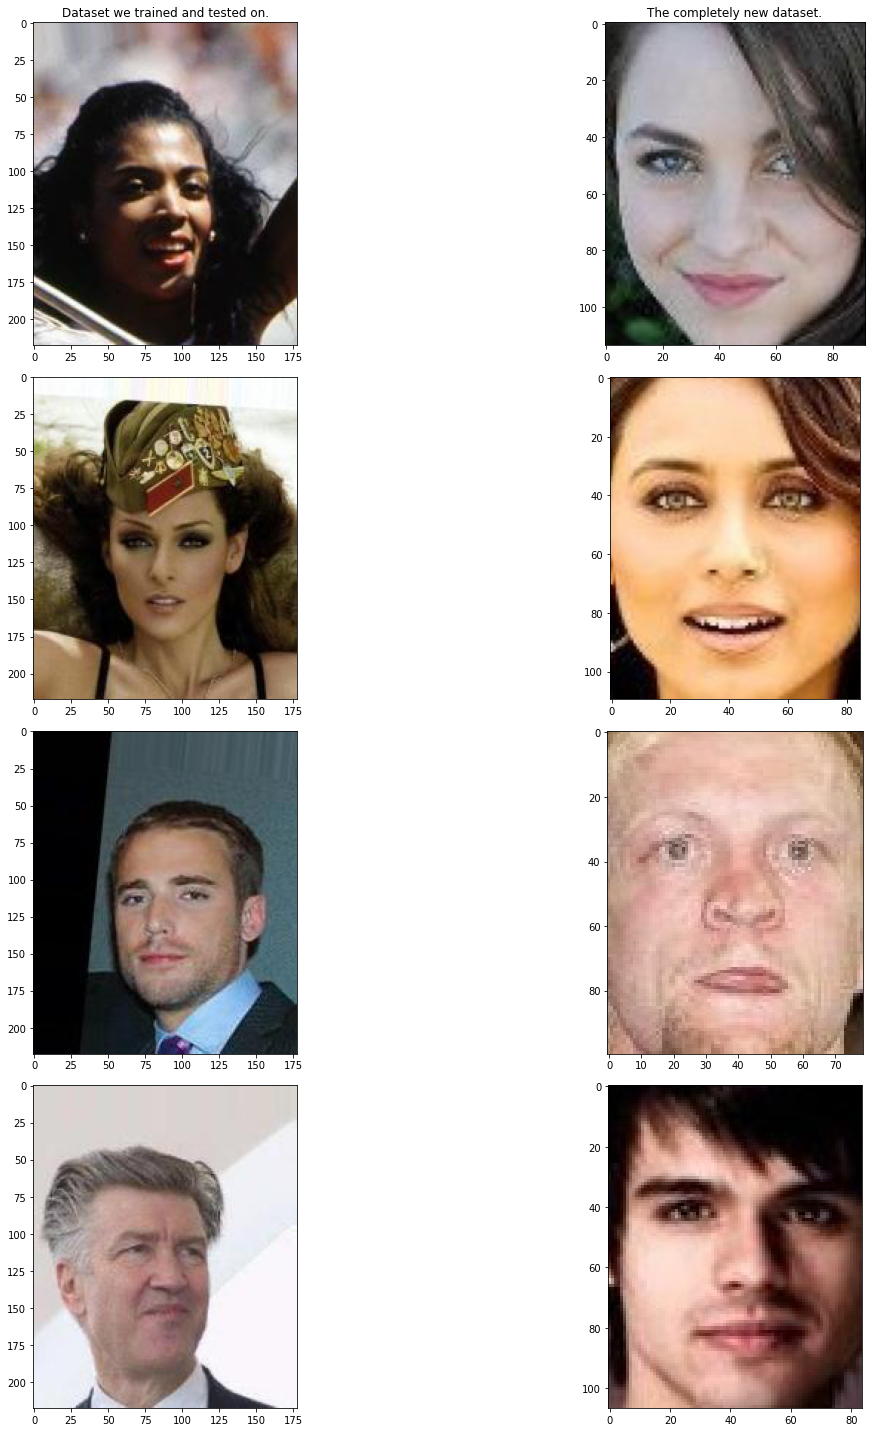

In [23]:
fig,ax=plt.subplots(ncols=2,nrows=4,figsize=(20,20))
img1 = mpimg.imread('../input/gender-recognition-200k-images-celeba/Dataset/Test/Female/160003.jpg')
ax[0][0].imshow(img1)
ax[0][0].set_title("Dataset we trained and tested on.")
img2 = mpimg.imread('../input/gender-classification-dataset/Training/female/131422.jpg.jpg')
ax[0][1].imshow(img2)
ax[0][1].set_title("The completely new dataset.")
img3 =  mpimg.imread('../input/gender-recognition-200k-images-celeba/Dataset/Validation/Female/180019.jpg')
ax[1][0].imshow(img3)
img4= mpimg.imread('../input/gender-classification-dataset/Validation/female/113010.jpg.jpg')
ax[1][1].imshow(img4)
img5 = mpimg.imread('../input/gender-recognition-200k-images-celeba/Dataset/Validation/Male/180028.jpg')
ax[2][0].imshow(img5)
img6 = mpimg.imread('../input/gender-classification-dataset/Validation/male/063517.jpg.jpg')
ax[2][1].imshow(img6)
ax[3][0].imshow(mpimg.imread('../input/gender-recognition-200k-images-celeba/Dataset/Validation/Male/180073.jpg'))
ax[3][1].imshow(mpimg.imread('../input/gender-classification-dataset/Validation/male/063531.jpg.jpg'))
plt.tight_layout()

Observe how different the new dataset is. It is low resoultion, and the images are zoomed in!

In [24]:
test_datagen2 = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen2.flow_from_directory(
'../input/gender-classification-dataset/Training',
target_size=(250,250),
batch_size=64,
class_mode='binary')

Found 47009 images belonging to 2 classes.


In [26]:
test_loss, test_acc = model2.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)
print('test_loss:',test_loss)

test acc: 0.901562511920929
test_loss: 0.2943319082260132


In [27]:
test_datagen3 = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen1.flow_from_directory(
'../input/gender-classification-dataset/Validation',
target_size=(250,250),
batch_size=64,
class_mode='binary')

Found 11649 images belonging to 2 classes.


In [28]:
test_loss, test_acc = model2.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)
print('test_loss:',test_loss)

test acc: 0.9034374952316284
test_loss: 0.27164536714553833


Uh, the accuracy falls drastically (over 20%) and the error rate (loss) increases by 1100%

In [89]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('xception_v0_{epoch:02d}_{val_accuracy:.3f}.h5',
                                             save_best_only = True,
                                             monitor= 'val_accuracy',
                                             mode = 'max')

In [90]:
epochs = 12
batch_size=128
history2 = model2.fit(test_generator, epochs= epochs, validation_data= test_generator,
                    steps_per_epoch= len(test_generator.filenames)//batch_size,
                    validation_steps= len(test_generator.filenames)//batch_size,
                    callbacks= [checkpoint]
                    )

Epoch 1/12
91/91 [==============================] - 53s 553ms/step - loss: 0.3913 - accuracy: 0.8917 - val_loss: 0.2932 - val_accuracy: 0.9220
Epoch 2/12
91/91 [==============================] - 40s 440ms/step - loss: 0.1990 - accuracy: 0.9252 - val_loss: 0.2343 - val_accuracy: 0.9212
Epoch 3/12
91/91 [==============================] - 38s 420ms/step - loss: 0.1758 - accuracy: 0.9307 - val_loss: 0.1618 - val_accuracy: 0.9372
Epoch 4/12
91/91 [==============================] - 38s 414ms/step - loss: 0.1436 - accuracy: 0.9442 - val_loss: 0.1393 - val_accuracy: 0.9531
Epoch 5/12
91/91 [==============================] - 37s 404ms/step - loss: 0.1277 - accuracy: 0.9512 - val_loss: 0.1279 - val_accuracy: 0.9478
Epoch 6/12
91/91 [==============================] - 37s 407ms/step - loss: 0.1255 - accuracy: 0.9526 - val_loss: 0.1117 - val_accuracy: 0.9605
Epoch 7/12
91/91 [==============================] - 37s 404ms/step - loss: 0.1062 - accuracy: 0.9600 - val_loss: 0.0839 - val_accuracy: 0.9705

In [99]:
test_loss, test_acc = model2.evaluate(test_generator, steps=50)
print('test acc:', test_acc)
print('test_loss:',test_loss)

50/50 [==============================] - 16s 327ms/step - loss: 0.1962 - accuracy: 0.9200
test acc: 0.9200000166893005
test_loss: 0.19620683789253235


This tells us that the model is not yet prepared to deal with any set of male/female classification dataset, but I guess that is what deep learning is about. All models are somewhat specific to the kind of the data they were trained on.


What should be changed to better the generalization of the model?

Should more features be augmented? (Horizontal/Vertical flips, Rotation etc). 

Should I stop trying to fit my model on a totally new dataset? (Is it a waste of time?)

**What do you think?**

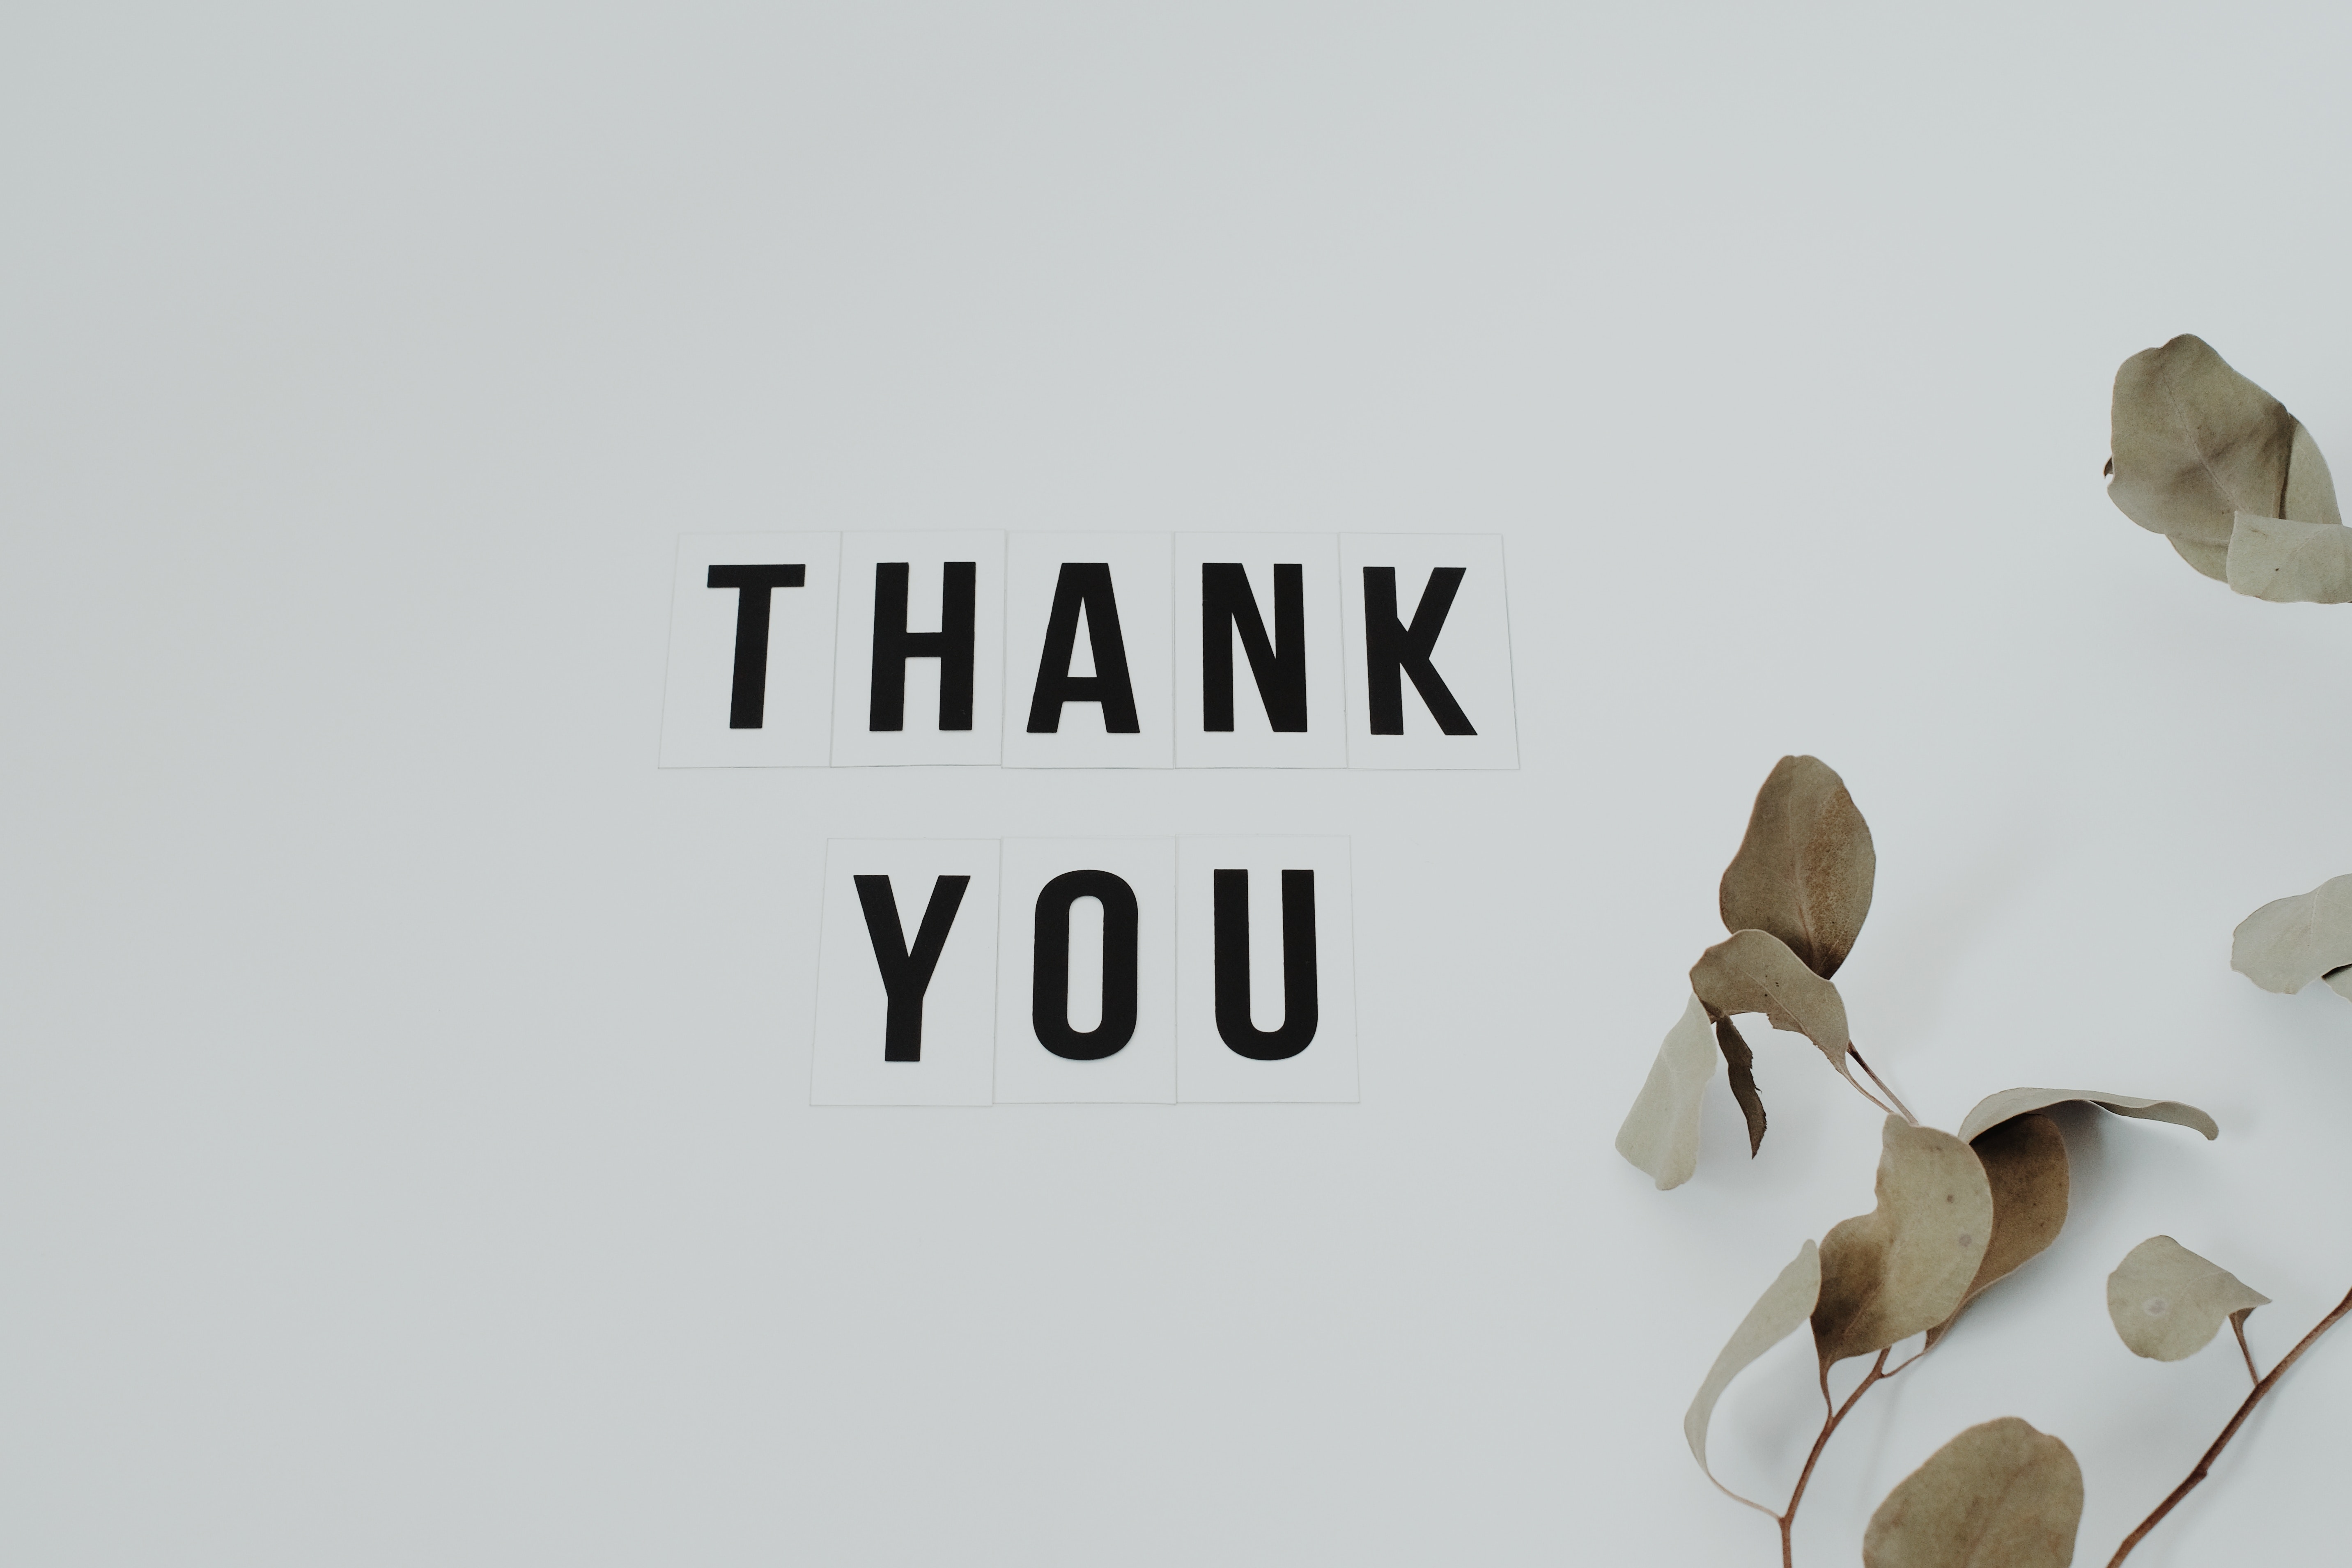

In [45]:
import os
os.walk('/kaggle/working')

<generator object walk at 0x7fb800094dd0>

In [102]:
os.remove("./xception_v0_04_0.953.h5")
os.remove("./xception_v0_07_0.970.h5")
os.remove("./xception_v0_03_0.937.h5")
os.remove("./xception_v5_01_0.937.h5")
os.remove("./xception_v0_01_0.922.h5")
os.remove("./xception_v0_06_0.961.h5")
os.remove("./xception_v4_01_0.938.h5")
os.remove("./xception_v0_09_0.982.h5")
os.remove("./xception_v0_12_0.988.h5")



For going through this notebook

**Also, I am fairly new to data science and machine and I still hope that you found something useful in this notebook.** 